In [1]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
import pyart
import xarray as xr
import pandas as pd
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Populating the interactive namespace from numpy and matplotlib


/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
Gen = ImageDataGenerator(rescale=1/255.)
dataset = Gen.flow_from_directory(
    '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training', class_mode='input', target_size=(256, 128), shuffle=False)

#inp, encoder, decoded = encoder_decoder_model()
model = load_model('/homes/rjackson/encoder/encoder-decoder-2000.hdf5')
encoder = Model(model.get_layer("input").output, model.get_layer("encoding").output)
encodings = encoder.predict(dataset)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Found 10740 images belonging to 3 classes.


In [3]:
dataset.filepaths

['/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments1.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments10.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments11.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments4.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments5.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments6.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments8.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.010112.moments9.png',
 '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/sgpdlacfC1.a1.20170802.020112.moments0.png',
 '/lambda_stor/da

In [3]:
times = []
for fname in dataset.filepaths:
    filename = fname.split('/')[-1].split('.')
    base_date = datetime.datetime.strptime('%s.%s' % (filename[2], filename[3]), '%Y%m%d.%H%M%S')
    num_times = int(filename[4].split('moments')[1])
    times.append(base_date + timedelta(minutes=5*num_times))

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
my = 'moments4'
my = my.split('moments')
my

['', '4']

In [4]:
encodings = encodings.reshape((encodings.shape[0], np.prod(encodings.shape[1:])))
encodings.shape

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10740, 2048)

In [15]:
## Reduce to 10-dimensional space

In [5]:
model = PCA(n_components=10)
model.fit(encodings)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PCA(n_components=10)

In [6]:
reduced = model.transform(encodings)
reduced.shape

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10740, 10)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


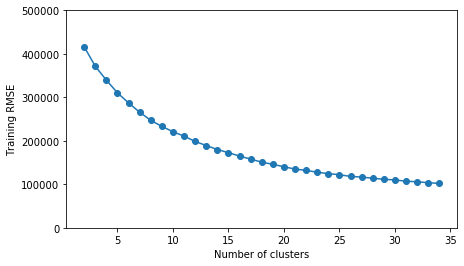

In [10]:
inertia = np.nan*np.ones(35)
for i in range(2, 35):
    km = KMeans(n_clusters=i)
    km.fit(reduced)
    inertia[i] = km.inertia_
plt.figure(figsize=(7, 4))    
plt.plot(inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Training RMSE')
plt.ylim([0, 500000.])
plt.savefig('Clusters.png', dpi=300)

In [7]:
cluster = KMeans(n_clusters=6)
cluster.fit(reduced)
cluster_no = cluster.labels_

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


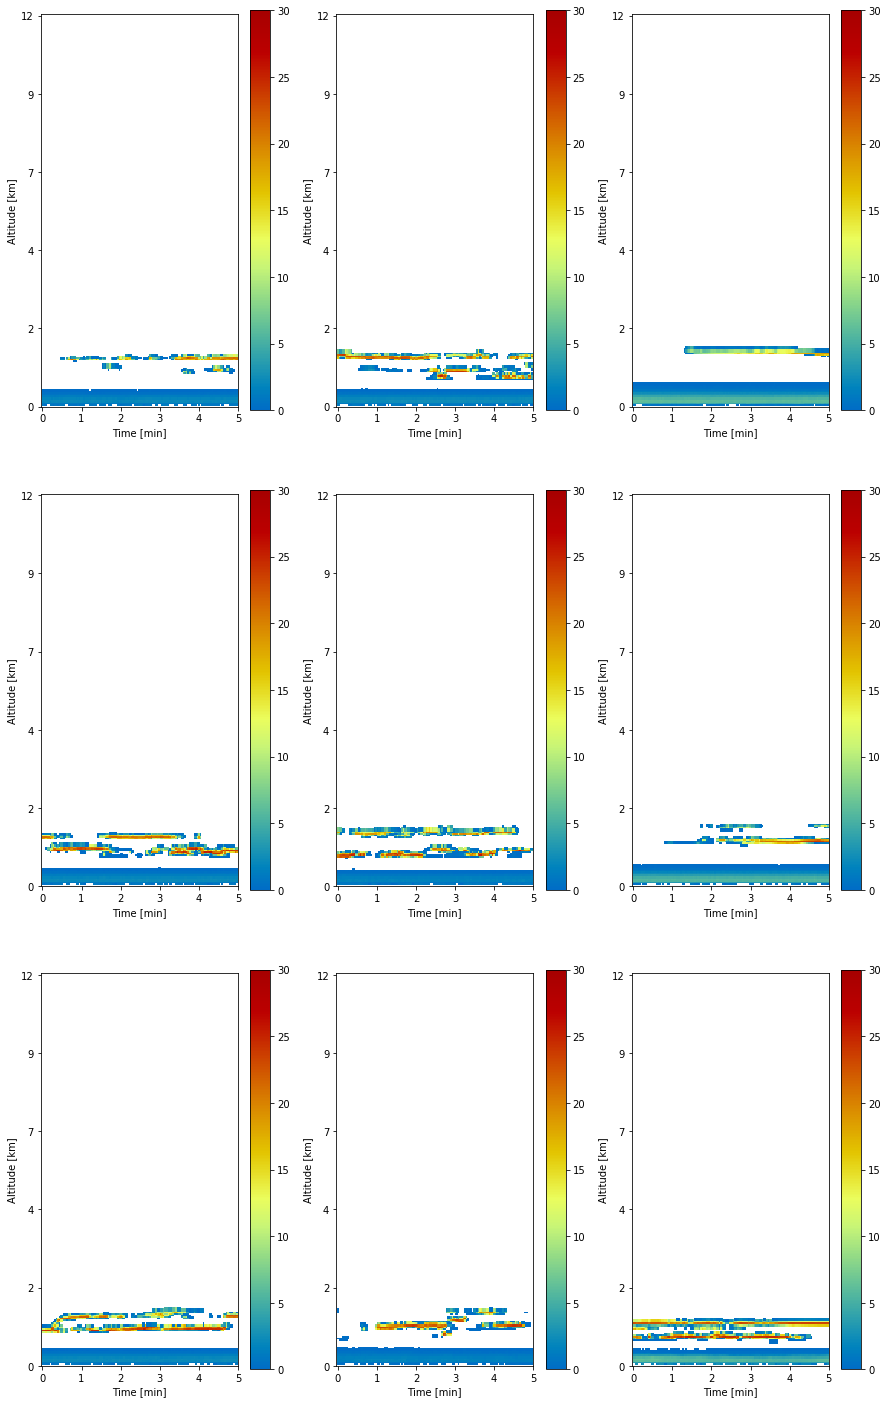

In [22]:
which = 5
cluster_ind = np.argwhere(cluster_no == which)
fig, ax = plt.subplots(3, 3, figsize=(15, 25))
for i in range(9):
    batch_no = int(np.floor(cluster_ind[i] / 32))
    img_no = cluster_ind[i] % 32
    img = np.squeeze(dataset[batch_no][0][img_no])
    im = ax[i % 3][int(i/3)].imshow(img)
    im = ax[i % 3][int(i/3)].pcolormesh(-np.ones_like(img[0]), -np.ones_like(img[0]), 
                                   img[0], cmap='pyart_HomeyerRainbow', vmin=0, vmax=30)
    ax[i % 3][int(i/3)].set_yticks(np.linspace(0, 256, 6))
    ax[i % 3][int(i/3)].set_yticklabels(['%d' % x for x in np.linspace(12, 0, 6)])
    ax[i % 3][int(i/3)].set_xticks(np.linspace(0, 128, 6))
    ax[i % 3][int(i/3)].set_xticklabels(['0', '1', '2', '3', '4', '5'])
    ax[i % 3][int(i/3)].set_xlabel('Time [min]')
    ax[i % 3][int(i/3)].set_ylabel("Altitude [km]")
    bar = plt.colorbar(im, ax=ax[i % 3][int(i/3)])
    #ax[i % 3][int(i/3)].axis('off')
    fig.savefig('cluster%d.png' % which)

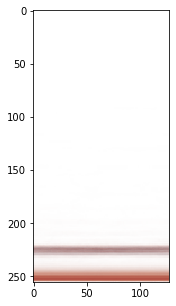

In [43]:
which = 5
cluster_ind = np.argwhere(cluster_no == which)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
img = np.squeeze(np.zeros_like(dataset[0][0][0]))
for i in range(len(cluster_ind)):
    batch_no = int(np.floor(cluster_ind[i] / 32))
    img_no = cluster_ind[i] % 32
    img = img + np.squeeze(dataset[batch_no][0][img_no])
img = img/len(cluster_ind)
plt.imshow(img)

In [9]:
scp_ds = xr.open_mfdataset('/lambda_stor/data/rjackson/coverage_product/*.nc')

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may wa

In [58]:
scp_ds['snrgt1.000000']

,Array,Chunk
Bytes,11.63 MB,10.30 kB
Shape,"(14679, 99)","(13, 99)"
Count,3810 Tasks,1270 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,11.63 MB,10.30 kB
Shape,"(14679, 99)","(13, 99)"
Count,3810 Tasks,1270 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [10]:
cluster_ds = xr.Dataset({'time': ('time', np.array(times)), 'classification': ('time', cluster_no)})
cluster_ds = cluster_ds.sortby('time')
cluster_ds = cluster_ds.reindex(time=scp_ds.time, method='nearest')
cluster_ds.to_netcdf('Clusters.nc')

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
cluster_ds
scp_ds.load()

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:                   (range_bins: 99, time: 14679)
Coordinates:
  * range_bins                (range_bins) float64 60.0 180.0 ... 1.182e+04
  * time                      (time) datetime64[ns] 2017-06-30T20:10:00 ... 2017-09-24T23:55:00
Data variables:
    snr25                     (time, range_bins) float64 nan nan ... 2.224 nan
    snr50                     (time, range_bins) float64 nan nan ... 2.287 nan
    snr75                     (time, range_bins) float64 nan nan ... 2.399 nan
    snrmin                    (time, range_bins) float64 nan nan ... 2.135 nan
    snrmax                    (time, range_bins) float64 nan nan ... 2.665 nan
    snrgt1.000000             (time, range_bins) float64 27.74 100.0 ... 0.0 0.0
    snrgt3.000000             (time, range_bins) float64 0.0 0.0 0.0 ... 0.0 0.0
    snrgt5.000000             (time, range_bins) float64 0.0 0.0 0.0 ... 0.0 0.0
    snrgt10.000000            (time, range_bins) float64 0.0 0.0 0.0 ... 0.0 0.0
    mean_velocity25           (time, range_bins) float64 nan nan ... -0.9922 nan
    mean_velocity50           (time, range_bins) float64 nan nan ... -0.856 nan
    mean_velocity75           (time, range_bins) float64 nan nan ... -0.7064 nan
    mean_velocitymin          (time, range_bins) float64 nan nan ... -1.338 nan
    mean_velocitymax          (time, range_bins) float64 nan nan ... nan
    mean_velocitygt-5.000000  (time, range_bins) float64 27.74 100.0 ... 0.0 0.0
    mean_velocitygt0.000000   (time, range_bins) float64 0.4573 0.4573 ... 0.0
    mean_velocitygt5.000000   (time, range_bins) float64 0.0 0.0 0.0 ... 0.0 0.0
    spectral_width25          (time, range_bins) float64 nan nan ... 5.541 nan
    spectral_width50          (time, range_bins) float64 nan nan ... 5.706 nan
    spectral_width75          (time, range_bins) float64 nan nan ... 6.088 nan
    spectral_widthmin         (time, range_bins) float64 nan nan ... 5.191 nan
    spectral_widthmax         (time, range_bins) float64 nan nan ... 6.598 nan
    spectral_widthgt1.000000  (time, range_bins) float64 24.7 99.7 ... 0.0 0.0
    spectral_widthgt3.000000  (time, range_bins) float64 24.7 99.7 ... 0.0 0.0
    spectral_widthgt5.000000  (time, range_bins) float64 24.7 99.7 ... 0.0 0.0
    spectral_widthgt7.000000  (time, range_bins) float64 2.439 0.1524 ... 0.0

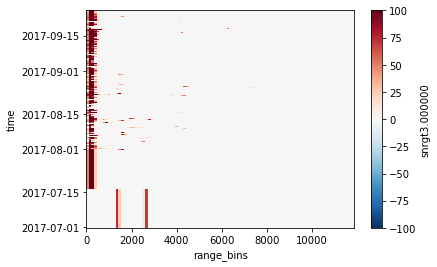

In [51]:
scp_ds['snrgt3.000000'].plot()

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


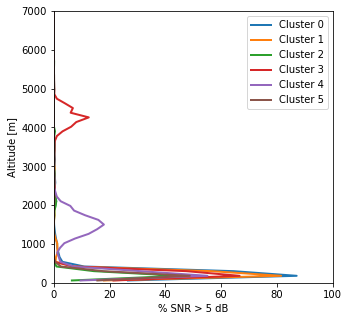

In [22]:
scp_ds = scp_ds.fillna(-1)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for cl in range(6):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    hist_bins = np.linspace(0, 100., 50)
    x, y = np.meshgrid(hist_bins[1:], scp_ds.range_bins.values, indexing='ij')
    mean_d = np.zeros((len(scp_ds.range_bins),))
    ninety_d = np.zeros((len(scp_ds.range_bins),))
    ten_d = np.zeros((len(scp_ds.range_bins),))
    for i in range(len(scp_ds.range_bins)):
        mean_d[i] = np.nanmean(scp_ds['snrgt5.000000'].values[inds, i])
        ninety_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 90)
        ten_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 10)
    ninety_d = np.where(ninety_d > 0, ninety_d, 0.001)
    ten_d = np.where(ten_d > 0, ten_d, 0.001)
    ax.plot(mean_d, scp_ds.range_bins.values, linewidth=2, label='Cluster %d' % cl)
    #ax.set_title('Cluster %d' % cl)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 7000])
    ax.set_xlabel('% SNR > 5 dB')
    ax.set_ylabel('Altitude [m]')
ax.legend()
fig.savefig('SNRgt5.png', dpi=300)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


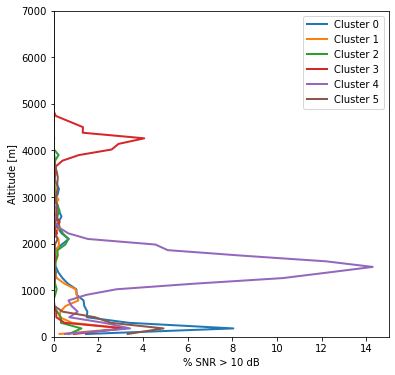

In [24]:
scp_ds = scp_ds.fillna(-1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for cl in range(6):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    hist_bins = np.linspace(0, 100., 50)
    x, y = np.meshgrid(hist_bins[1:], scp_ds.range_bins.values, indexing='ij')
    mean_d = np.zeros((len(scp_ds.range_bins),))
    ninety_d = np.zeros((len(scp_ds.range_bins),))
    ten_d = np.zeros((len(scp_ds.range_bins),))
    for i in range(len(scp_ds.range_bins)):
        mean_d[i] = np.nanmean(scp_ds['snrgt10.000000'].values[inds, i])
        ninety_d[i] = np.nanpercentile(scp_ds['snrgt10.000000'].values[inds, i], 90)
        ten_d[i] = np.nanpercentile(scp_ds['snrgt10.000000'].values[inds, i], 10)
    ninety_d = np.where(ninety_d > 0, ninety_d, 0.001)
    ten_d = np.where(ten_d > 0, ten_d, 0.001)
    ax.plot(mean_d, scp_ds.range_bins.values, linewidth=2, label='Cluster %d' % cl)
    #ax.set_title('Cluster %d' % cl)
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 7000])
    ax.set_xlabel('% SNR > 10 dB')
    ax.set_ylabel('Altitude [m]')
ax.legend()
fig.savefig('SNRgt10.png', dpi=300)

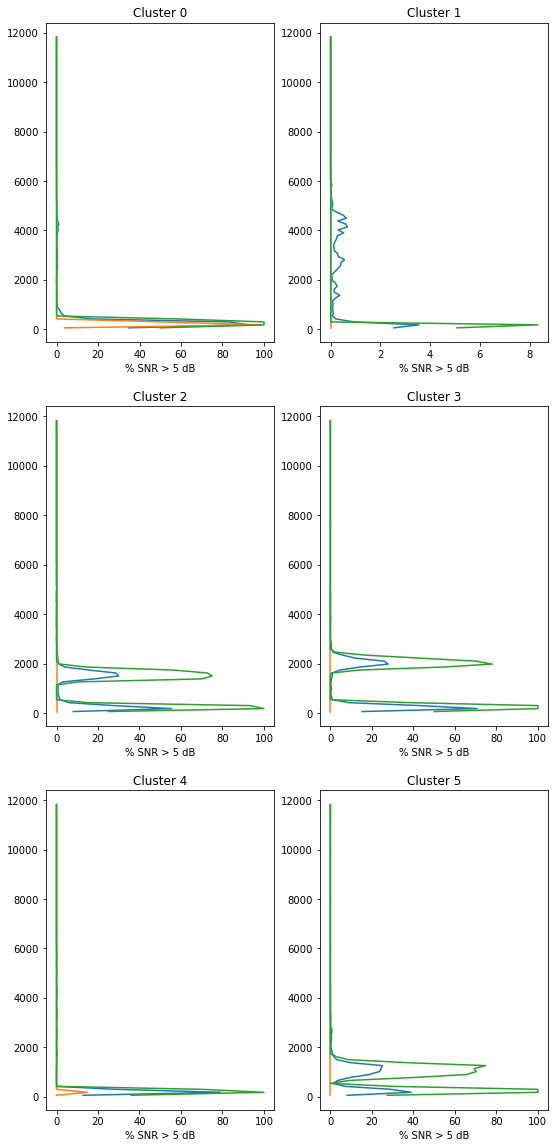

In [108]:
scp_ds = scp_ds.fillna(-1)
fig, ax = plt.subplots(3, 2, figsize=(9, 20))
for cl in range(6):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    hist_bins = np.linspace(0, 100., 50)
    x, y = np.meshgrid(hist_bins[1:], scp_ds.range_bins.values, indexing='ij')
    mean_d = np.zeros((len(scp_ds.range_bins),))
    ninety_d = np.zeros((len(scp_ds.range_bins),))
    ten_d = np.zeros((len(scp_ds.range_bins),))
    for i in range(len(scp_ds.range_bins)):
        mean_d[i] = np.nanmean(scp_ds['snrgt5.000000'].values[inds, i])
        ninety_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 90)
        ten_d[i] = np.nanpercentile(scp_ds['snrgt5.000000'].values[inds, i], 10)
    ax[int(cl/2), cl%2].plot(mean_d, scp_ds.range_bins.values)
    ax[int(cl/2), cl%2].plot(ten_d, scp_ds.range_bins.values)
    ax[int(cl/2), cl%2].plot(ninety_d, scp_ds.range_bins.values)
    ax[int(cl/2), cl%2].set_title('Cluster %d' % cl)
    ax[int(cl/2), cl%2].set_xlabel('% SNR > 5 dB')

In [16]:
label_df = pd.read_csv('../notebooks/lidar_labels.csv')

date_list = np.array([datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in label_df["Date"].values])
start_time_list = np.array([datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values])
end_time_list = np.array([datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values])


def get_label(dt):
    label_ind = np.where(np.logical_and.reduce(
        (date_list == dt.date(), start_time_list <= dt.time(), end_time_list > dt.time())))
    if not label_ind[0].size:
        return -1
    my_strings = np.array(
            [x.lower() for x in label_df["Label"].values[label_ind]])
    num_cloud = len(np.where(my_strings == "cloudy")[0]) + \
            len(np.where(my_strings == "cloud")[0])
    num_clear = len(np.where(my_strings == "clear")[0])
    num_rain = len(np.where(my_strings == "rain")[0])
    my_string = label_df["Label"].values[label_ind][0]

    pct_cloud = num_cloud/len(my_strings)

    if num_rain > 0:
        return 2
    elif pct_cloud < 0.25:
        return 0
    elif pct_cloud >= 0.25 and pct_cloud <= 0.75:
        return 1
    else:
        return 1

    raise ValueError("Invalid value %s for label" % my_string)

labels = np.array([get_label(x) for x in times])

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


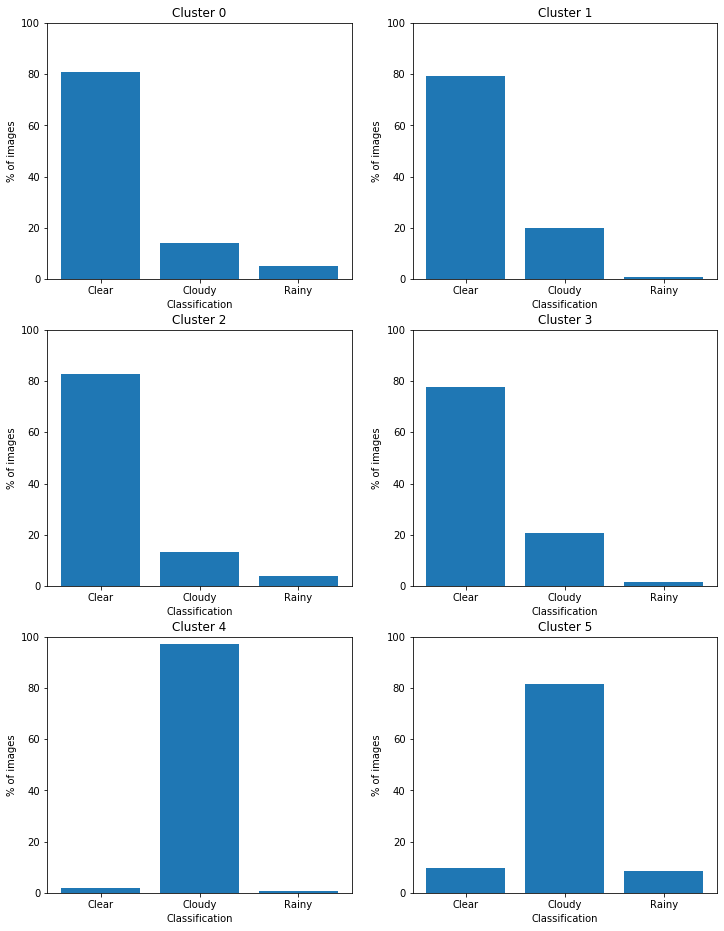

In [17]:
cluster_ds = xr.Dataset({'time': ('time', np.array(times)), 'classification': ('time', cluster_no)})
#cluster_ds = cluster_ds.sortby('time')
fig, ax = plt.subplots(3, 2, figsize=(12, 16))
for cl in range(6):
    inds = np.argwhere(cluster_ds.classification.values == cl)
    num_clear = np.sum(labels[inds] == 0)
    num_cloudy = np.sum(labels[inds] == 1)
    num_rainy = np.sum(labels[inds] == 2)
    ax[int(cl/2), cl%2].bar([0, 1, 2], np.array([num_clear, num_cloudy, num_rainy])/(num_clear + num_cloudy + num_rainy)*100)
    ax[int(cl/2), cl%2].set_xticks([0, 1, 2])
    ax[int(cl/2), cl%2].set_xticklabels(['Clear', 'Cloudy', 'Rainy'])
    ax[int(cl/2), cl%2].set_ylabel('% of images')
    ax[int(cl/2), cl%2].set_xlabel('Classification')
    ax[int(cl/2), cl%2].set_ylim([0, 100])
    ax[int(cl/2), cl%2].set_title('Cluster %d' % cl) 
fig.savefig('label_dist.png', dpi=300)

In [34]:
len(times)

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13480